# Resolución de la compuerta XOR mediante una red neuronal Feedforward usando backpropagation

![logoTSJ](https://upload.wikimedia.org/wikipedia/commons/c/ca/TSJZapopan_Logo.jpg)

- **Autor:** _Eduardo Efrain Garcia Sarez_

  > **06/11/2025**

- **Institución:** **Instituto Tecnológico Superior de Jalisco (TSJ)**.  
- **Carrera:** **Ingeniería en Sistemas Computacionales**

En este notebook nos centraremos en implementar una **FNN** (Feedforward Neural Network) capaz de aprender el patrón de la compuerta lógica **XOR**. El pipeline será el siguiente:

1. **Justificación del problema**
    - Fundamentos teóricos de la arquitectura neuronal
    - Análisis del problema XOR y su no-linealidad
2. **Fundamentos matemáticos**
    - Técnica de aprendizaje (forward pass)
        - Vector de entrada y pesos
        - Función de activación
        - Propagación hacia adelante
    - Técnica de ajuste de pesos (backpropagation)
        - Cálculo del error
        - Actualización de pesos
3. **Implementación**
    - Arquitectura de la red
    - Código fuente y entrenamiento
    - Visualización y evaluación del modelo
4. **Conclusiones y resultados**
    - Análisis de convergencia
    - Comparación con otras soluciones
    - Limitaciones y posibles mejoras

## Justificación del problema

Aunque no es estrictamente necesario usar una red neuronal para resolver la compuerta XOR, este ejercicio es excelente para aprender la implementación de una _red neuronal multicapa_ (multilayer perceptron).

En este documento entenderemos por _red neuronal multicapa_ a una red que tiene al menos las siguientes capas: **neuronas de entrada** (input layer), una o más **capas ocultas** (hidden layers) y una o más **neuronas de salida** (output layer). Bajo este esquema, la red se vería así:

![network](image.png)

_Figura 1: Red neuronal multicapa._

---

Ahora, **¿por qué utilizar una FNN y no otra arquitectura como CNN, RNN o Transformers?**

La elección de este tipo de red se debe a que su uso más común es el de **separar datos** que están distribuidos en **regiones lineales**.  
Para este tipo de datos, las _FNN_ nos proporcionan una solución ideal.  

Debido a que los datos en la compuerta _XOR_ están separados por **dos regiones lineales**, como se muestra a continuación, este tipo de red resulta **ideal** para nuestro caso.

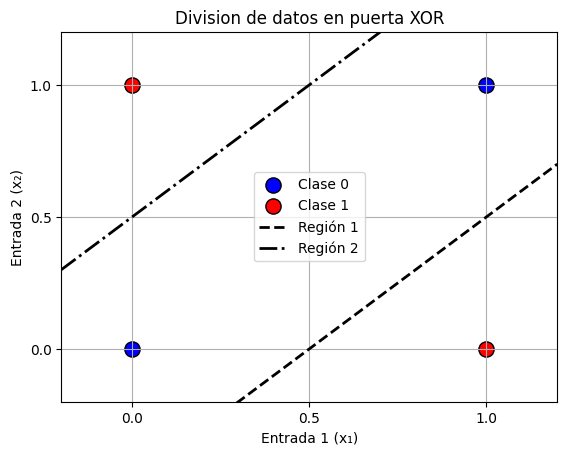

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Datos XOR
XOR_gate = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

y = np.array([0, 1, 1, 0])

# Graficar los puntos
for i, label in enumerate(y):
    color = "blue" if label == 0 else "red"
    plt.scatter(
        XOR_gate[i, 0],
        XOR_gate[i, 1],
        color=color,
        s=120,
        edgecolor="k",
        label=f"Clase {label}" if i < 2 else "",
    )

# Dibujar las dos regiones lineales (líneas de separación)
# Línea 1: y = x - 0.5
x_line = np.linspace(-0.2, 1.2, 100)
plt.plot(x_line, x_line - 0.5, "k--", linewidth=2, label="Región 1")

# Línea 2: y = -x + 1.5
plt.plot(x_line, x_line + 0.5, "k-.", linewidth=2, label="Región 2")

# Decoración
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.xticks([0, 0.5, 1])
plt.yticks([0, 0.5, 1])
plt.xlabel("Entrada 1 (x₁)")
plt.ylabel("Entrada 2 (x₂)")
plt.title("Division de datos en puerta XOR")
plt.legend()
plt.grid(True)
plt.show()


---

Podemos ver claramente cómo los datos pueden ser separados en **2 regiones lineales**. Al detectarse más de una región, este se convierte en un problema no apto para una red de una capa única (**perceptrón**).

Nuestras redes multicapa siguen el mismo esquema de un perceptrón, el cual es el siguiente:

![perceptron](https://94fa3c88.delivery.rocketcdn.me/es/files/2021/03/perceptron-formule.png)

_Figura 2: Perceptrón_

Sus características son las mismas:

1. **Entradas**
2. **Pesos**
3. **Cálculo del vector**
4. **Función de activación**

---

La diferencia con un esquema multicapa es que las salidas de los perceptrones posteriores a los de la capa de entrada reciben como datos de entrada las salidas de los perceptrones anteriores. Cada perceptrón en las capas intermedias (_hidden_) recibe la salida de los perceptrones en la capa de entrada, y estos a su vez apuntan su salida a la siguiente capa de perceptrones, todos ellos conectados entre sí. Al darse este flujo en una sola dirección, se les conoce como redes **FeedForward**. La siguiente animación ejemplifica la conexión entre las capas y el flujo de información:

![gif feedforward](https://miro.medium.com/v2/resize:fit:1400/0*vHFhOPRkLp-adUg8.gif)

_Figura 3: FNN: FeedForward Neural Network_

### **Fundamentos matemáticos de la técnica de aprendizaje (forward pass)**

#### _Paso 1: Vector de entrada_

Sea la red neuronal un **perceptrón multicapa (MLP)** con $(n)$ entradas.  
El vector de entrada se representa como:

$\mathbf{x} = [x_1, x_2, \dots, x_n]^T, \quad \mathbf{x} \in \mathbb{R}^n$

La red recibe un vector de datos de entrada, cuyos elementos generalmente pertenecen al conjunto de números reales $(x_i \in \mathbb{R})$. Este vector representa la información que será procesada por las capas de la red.

#### _Paso 2: Inicialización de vector de pesos_

Cada neurona en la red está conectada a las entradas mediante **pesos sinápticos**.  
El vector de pesos de la neurona $(m)$-ésima en una capa se denota como:

$\mathbf{w}^m = [w_1^m, w_2^m, \dots, w_n^m]^T, \quad \mathbf{w}^m \in \mathbb{R}^n$

Los pesos deben inicializarse con **valores aleatorios**, generalmente en un rango pequeño como $[-1,1]$ o $[0.1,1]$. Esta inicialización ayuda a romper la simetría y facilita el aprendizaje.

$w_i^m \sim \mathcal{U}(-1,1)$

donde $\mathcal{U}(-1,1)$ indica una **distribución uniforme** en el intervalo $[-1,1]$.

#### _Paso 3: Producto ponderado y sesgo_

Cada neurona realiza un **producto punto** entre su vector de pesos y las entradas, y luego agrega un **sesgo** $(b^m)$:

$[z^m = \mathbf{w}^{m} \cdot \mathbf{x} + b^m = \sum_{i=1}^{n} w_i^m x_i + b^m]$

El valor $(z^m)$ es conocido como **potencial de activación** de la neurona antes de aplicar la función de activación.

#### _Paso 4: Paso por la función de activación_

Para introducir **no linealidad** y permitir que la red aprenda fronteras complejas, se aplica una función de activación $(\phi)$. Comúnmente se utilizan funciones como _sigmoide_, _tanh_, o _ReLU_, dependiendo de la arquitectura y el problema. En este caso, se opta por una función **sigmoide**:

$\sigma(z^m) = \frac{1}{1 + e^{-z^m}}$

donde:

- $z^m$ es el **potencial de activación** calculado en el paso anterior.
- $\sigma(z^m)$ es el resultado de pasar $(z^m)$ a través de la función sigmoide.

#### _Paso 5: Propagación hacia adelante (FeedForward)_

En una **red multicapa**, los vectores de salida de una capa se convierten en las entradas de la siguiente:

$[
\mathbf{z_m}^{(l+1)} = \phi \big( \mathbf{W}^{(l)} \mathbf{z}^{(l)} + \mathbf{b}^{(l)} \big)
]$

donde:  

- $(l)$ = índice de la capa  
- $(\mathbf{W}^{(l)})$ = matriz de pesos de la capa $(l)$  
- $(\mathbf{b}^{(l)})$ = vector de sesgos de la capa $(l)$  
- $(\mathbf{z}^{(l)})$ = vector de activaciones de la capa $(l)$

Esta operación se repite hasta la capa de salida.

---

### **Fundamentos matemáticos del ajuste de pesos (backpropagation).**

El **backpropagation** es el algoritmo que permite **ajustar los pesos y sesgos** de una red neuronal multicapa, minimizando un **error o función de costo**. El proceso se realiza de manera **hacia atrás**, desde la capa de salida hasta la capa de entrada, aplicando la regla de la cadena para calcular los gradientes.

#### _Paso 1: Cálculo del error en la capa de salida_

Una vez que la red ha realizado la propagación hacia adelante, se calcula el **error** entre la predicción y el valor esperado. Sea $\mathbf{y}$ el vector de salida deseado y $\mathbf{\hat{y}}$ la salida predicha por la red.

El error se cuantifica comúnmente mediante el **Error Cuadrático Medio (MSE)**, quedando con la forma:

$J = \frac{1}{2} \sum_{j=1}^{k} (y_j - \hat{y}_j)^2$

donde $(k)$ es el número de neuronas en la capa de salida y $(J)$ la **función de costo**.

#### _Paso 2: Gradiente del error en la capa de salida_

Para ajustar los pesos, necesitamos calcular cómo el error cambia respecto a los pesos. Comenzamos con la **derivada del error** en la última capa $(L)$:

$\delta^{(L)} = \frac{\partial J}{\partial z^{(L)}} = (y - \hat{y}) \odot \phi'(z^{(L)})$

donde:

- $\delta^{(L)}$ es el **error local** o **gradiente** en la capa de salida
- $\odot$ denota el **producto elemento a elemento** (Hadamard)
- $\phi'(z^{(L)})$ es la **derivada de la función de activación**

Para la función **sigmoide**, su derivada es:

$\sigma'(z) = \sigma(z)(1 - \sigma(z))$

Entonces, la operación elemento a elemento es:

$\delta^{(L)} = (y - \hat{y}) \cdot \sigma(z_i^L)(1 - \sigma(z_i^L))$

#### _Paso 3: Propagación del error hacia capas anteriores_

El **error en la capa $l$** se calcula a partir del error de la capa siguiente $(l+1)$ mediante:

$$
\delta_i^{(l)} = \phi'(z_i^{(l)}) \sum_{j} w_{ij}^{(l+1)} \delta_j^{(l+1)}
$$

donde:  

- $w_{ij}^{(l+1)}$ = peso que conecta la neurona $i$ de la capa actual $l$ con la neurona $j$ de la capa siguiente $(l+1)$  
- $\delta_j^{(l+1)}$ = error de la neurona $j$ en la capa siguiente $(l+1)$  
- $\phi'(z_i^{(l)})$ = derivada de la función de activación de la neurona $i$ en la capa actual

Entonces, la operación elemento a elemento es:

$$
\delta^l = \sigma'(z) \cdot \big( w_1 \cdot \delta_1^{(l+1)} + w_2 \cdot \delta_2^{(l+1)} + w_3 \cdot \delta_3^{(l+1)} + \dots + w_n \cdot \delta_n^{(l+1)} \big)
$$

donde:

- $\delta^l$ representa el error en la neurona actual
- $\sigma'(z)$ representa la derivada de la función de activación
- $\delta_n^{(l+1)}$ el error de la neurona en la capa siguiente
- $w_n \cdot \delta_n^{(l+1)}$ cuánto error aportó cada peso a las neuronas siguientes

> **Nota:** El bias toma el mismo error de la neurona, de manera que no es necesario su cálculo, solo su actualización.

#### _Paso 4: Actualización de pesos y sesgos_

Una vez calculados los errores $\delta$, los **pesos** y **sesgos** se actualizan usando **descenso de gradiente**:

$$
w_{ij}^{(l)} \gets w_{ij}^{(l)} - \eta \, \delta_j^{(l)} \, z_i^{(l-1)}
$$

$$
b_j^{(l)} \gets b_j^{(l)} - \eta \, \delta_j^{(l)}
$$

donde:  

- $\eta$ = tasa de aprendizaje (**learning rate**), hiperparámetro que controla la magnitud de los ajustes en cada iteración
- $z_i^{(l-1)}$ = salida de la neurona $i$ en la capa anterior $(l-1)$

#### _Paso 5: Iteración del proceso_

El proceso completo de **forward pass** y **backpropagation** se repite para cada ejemplo de entrenamiento o lote de datos (**batch**) durante múltiples **épocas** (epochs), hasta que el error converja a un mínimo aceptable o se alcance un criterio de parada.

**Resumen del flujo completo:**

1. **Forward pass**: Propagación de datos desde entrada hasta salida
2. **Cálculo del error**: Comparación entre predicción y valor real
3. **Backward pass**: Retropropagación del error capa por capa
4. **Actualización**: Modificación de pesos y sesgos
5. **Iteración**: Repetición hasta convergencia

--- 

## **Ejemplo práctico: Resolución de la compuerta XOR**

### **Arquitectura de la red**

Para resolver el problema de la compuerta **XOR**, utilizaremos una red neuronal con la siguiente arquitectura:

- **Capa de entrada**: 2 neuronas $(x_1, x_2)$
- **Capa oculta**: 2 neuronas $(h_1, h_2)$
- **Capa de salida**: 1 neurona $(y)$

La tabla de verdad de XOR es:

| $x_1$ | $x_2$ | $y$ (salida esperada) |
|-------|-------|------------------------|
| 0     | 0     | 0                      |
| 0     | 1     | 1                      |
| 1     | 0     | 1                      |
| 1     | 1     | 0                      |

Para este ejemplo, utilizaremos el caso de entrada: **$x_1 = 1, x_2 = 0$**, con salida esperada **$y = 1$**.

---

### **Inicialización de pesos y sesgos**

Siguiendo el **Paso 2** del forward pass, inicializamos los pesos con valores aleatorios pequeños:

**Pesos de la capa de entrada a la capa oculta:**

$$
\mathbf{W}^{(1)} = \begin{bmatrix} 
w_{11}^{(1)} & w_{12}^{(1)} \\ 
w_{21}^{(1)} & w_{22}^{(1)}
\end{bmatrix} = \begin{bmatrix} 
0.5 & -0.6 \\ 
0.3 & 0.8
\end{bmatrix}
$$

**Sesgos de la capa oculta:**

$$
\mathbf{b}^{(1)} = \begin{bmatrix} 
b_1^{(1)} \\ 
b_2^{(1)}
\end{bmatrix} = \begin{bmatrix} 
0.1 \\ 
-0.2
\end{bmatrix}
$$

**Pesos de la capa oculta a la capa de salida:**

$$
\mathbf{W}^{(2)} = \begin{bmatrix} 
w_{11}^{(2)} \\ 
w_{21}^{(2)}
\end{bmatrix} = \begin{bmatrix} 
0.9 \\ 
-0.4
\end{bmatrix}
$$

**Sesgo de la capa de salida:**

$$
b^{(2)} = 0.3
$$

**Tasa de aprendizaje:**

$$
\eta = 0.5
$$

---

## **FORWARD PASS (Propagación hacia adelante)**

### **Paso 1: Vector de entrada**

Según el **Paso 1** del forward pass, nuestro vector de entrada es:

$$
\mathbf{x} = \begin{bmatrix} 
x_1 \\ 
x_2
\end{bmatrix} = \begin{bmatrix} 
1 \\ 
0
\end{bmatrix}
$$

---

### **Paso 2: Cálculo de la capa oculta**

Aplicando el **Paso 3** (producto ponderado y sesgo) para cada neurona de la capa oculta:

**Neurona oculta 1:**

$$
z_1^{(1)} = w_{11}^{(1)} \cdot x_1 + w_{21}^{(1)} \cdot x_2 + b_1^{(1)}
$$

$$
z_1^{(1)} = (0.5)(1) + (0.3)(0) + 0.1 = 0.6
$$

**Neurona oculta 2:**

$$
z_2^{(1)} = w_{12}^{(1)} \cdot x_1 + w_{22}^{(1)} \cdot x_2 + b_2^{(1)}
$$

$$
z_2^{(1)} = (-0.6)(1) + (0.8)(0) + (-0.2) = -0.8
$$

---

### **Paso 3: Aplicación de la función de activación (capa oculta)**

Siguiendo el **Paso 4** del forward pass, aplicamos la función sigmoide:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

**Para la neurona oculta 1:**

$$
a_1^{(1)} = \sigma(z_1^{(1)}) = \sigma(0.6) = \frac{1}{1 + e^{-0.6}} = \frac{1}{1 + 0.5488} = 0.6457
$$

**Para la neurona oculta 2:**

$$
a_2^{(1)} = \sigma(z_2^{(1)}) = \sigma(-0.8) = \frac{1}{1 + e^{0.8}} = \frac{1}{1 + 2.2255} = 0.3100
$$

---

### **Paso 4: Cálculo de la capa de salida**

Aplicando nuevamente el **Paso 3** (producto ponderado y sesgo):

$$
z^{(2)} = w_{11}^{(2)} \cdot a_1^{(1)} + w_{21}^{(2)} \cdot a_2^{(1)} + b^{(2)}
$$

$$
z^{(2)} = (0.9)(0.6457) + (-0.4)(0.3100) + 0.3
$$

$$
z^{(2)} = 0.5811 - 0.1240 + 0.3 = 0.7571
$$

---

### **Paso 5: Aplicación de la función de activación (capa de salida)**

$$
\hat{y} = \sigma(z^{(2)}) = \sigma(0.7571) = \frac{1}{1 + e^{-0.7571}} = \frac{1}{1 + 0.4689} = 0.6809
$$

**Resultado del forward pass:**
- **Salida predicha:** $\hat{y} = 0.6809$
- **Salida esperada:** $y = 1$
- **Error:** La red aún no predice correctamente, necesitamos ajustar los pesos.

---

## **BACKPROPAGATION (Propagación hacia atrás)**

### **Paso 1: Cálculo del error en la capa de salida**

Siguiendo el **Paso 1** del backpropagation, calculamos el error:

$$
J = \frac{1}{2}(y - \hat{y})^2 = \frac{1}{2}(1 - 0.6809)^2 = \frac{1}{2}(0.3191)^2 = 0.0509
$$

---

### **Paso 2: Gradiente del error en la capa de salida**

Aplicando el **Paso 2** del backpropagation:

$$
\delta^{(2)} = (y - \hat{y}) \cdot \sigma(z^{(2)}) \cdot (1 - \sigma(z^{(2)}))
$$

$$
\delta^{(2)} = (1 - 0.6809) \cdot (0.6809) \cdot (1 - 0.6809)
$$

$$
\delta^{(2)} = (0.3191) \cdot (0.6809) \cdot (0.3191) = 0.0693
$$

---

### **Paso 3: Propagación del error hacia la capa oculta**

Siguiendo el **Paso 3** del backpropagation, calculamos el error para cada neurona oculta:

**Para la neurona oculta 1:**

$$
\delta_1^{(1)} = \sigma'(z_1^{(1)}) \cdot w_{11}^{(2)} \cdot \delta^{(2)}
$$

$$
\delta_1^{(1)} = [a_1^{(1)} \cdot (1 - a_1^{(1)})] \cdot w_{11}^{(2)} \cdot \delta^{(2)}
$$

$$
\delta_1^{(1)} = [0.6457 \cdot (1 - 0.6457)] \cdot (0.9) \cdot (0.0693)
$$

$$
\delta_1^{(1)} = (0.6457 \cdot 0.3543) \cdot (0.9) \cdot (0.0693) = 0.0143
$$

**Para la neurona oculta 2:**

$$
\delta_2^{(1)} = \sigma'(z_2^{(1)}) \cdot w_{21}^{(2)} \cdot \delta^{(2)}
$$

$$
\delta_2^{(1)} = [a_2^{(1)} \cdot (1 - a_2^{(1)})] \cdot w_{21}^{(2)} \cdot \delta^{(2)}
$$

$$
\delta_2^{(1)} = [0.3100 \cdot (1 - 0.3100)] \cdot (-0.4) \cdot (0.0693)
$$

$$
\delta_2^{(1)} = (0.3100 \cdot 0.6900) \cdot (-0.4) \cdot (0.0693) = -0.0059
$$

---

### **Paso 4: Actualización de pesos de la capa de salida**

Aplicando el **Paso 4** del backpropagation:

**Peso $w_{11}^{(2)}$ (de neurona oculta 1 a salida):**

$$
w_{11}^{(2)} \gets w_{11}^{(2)} - \eta \cdot \delta^{(2)} \cdot a_1^{(1)}
$$

$$
w_{11}^{(2)} \gets 0.9 - (0.5) \cdot (0.0693) \cdot (0.6457) = 0.9 - 0.0224 = 0.8776
$$

**Peso $w_{21}^{(2)}$ (de neurona oculta 2 a salida):**

$$
w_{21}^{(2)} \gets w_{21}^{(2)} - \eta \cdot \delta^{(2)} \cdot a_2^{(1)}
$$

$$
w_{21}^{(2)} \gets -0.4 - (0.5) \cdot (0.0693) \cdot (0.3100) = -0.4 - 0.0107 = -0.4107
$$

**Sesgo $b^{(2)}$:**

$$
b^{(2)} \gets b^{(2)} - \eta \cdot \delta^{(2)}
$$

$$
b^{(2)} \gets 0.3 - (0.5) \cdot (0.0693) = 0.3 - 0.0347 = 0.2653
$$

---

### **Paso 5: Actualización de pesos de la capa oculta**

**Peso $w_{11}^{(1)}$ (de entrada $x_1$ a neurona oculta 1):**

$$
w_{11}^{(1)} \gets w_{11}^{(1)} - \eta \cdot \delta_1^{(1)} \cdot x_1
$$

$$
w_{11}^{(1)} \gets 0.5 - (0.5) \cdot (0.0143) \cdot (1) = 0.5 - 0.0072 = 0.4928
$$

**Peso $w_{21}^{(1)}$ (de entrada $x_2$ a neurona oculta 1):**

$$
w_{21}^{(1)} \gets w_{21}^{(1)} - \eta \cdot \delta_1^{(1)} \cdot x_2
$$

$$
w_{21}^{(1)} \gets 0.3 - (0.5) \cdot (0.0143) \cdot (0) = 0.3 - 0 = 0.3
$$

**Peso $w_{12}^{(1)}$ (de entrada $x_1$ a neurona oculta 2):**

$$
w_{12}^{(1)} \gets w_{12}^{(1)} - \eta \cdot \delta_2^{(1)} \cdot x_1
$$

$$
w_{12}^{(1)} \gets -0.6 - (0.5) \cdot (-0.0059) \cdot (1) = -0.6 + 0.0030 = -0.5970
$$

**Peso $w_{22}^{(1)}$ (de entrada $x_2$ a neurona oculta 2):**

$$
w_{22}^{(1)} \gets w_{22}^{(1)} - \eta \cdot \delta_2^{(1)} \cdot x_2
$$

$$
w_{22}^{(1)} \gets 0.8 - (0.5) \cdot (-0.0059) \cdot (0) = 0.8 - 0 = 0.8
$$

**Sesgo $b_1^{(1)}$:**

$$
b_1^{(1)} \gets b_1^{(1)} - \eta \cdot \delta_1^{(1)}
$$

$$
b_1^{(1)} \gets 0.1 - (0.5) \cdot (0.0143) = 0.1 - 0.0072 = 0.0928
$$

**Sesgo $b_2^{(1)}$:**

$$
b_2^{(1)} \gets b_2^{(1)} - \eta \cdot \delta_2^{(1)}
$$

$$
b_2^{(1)} \gets -0.2 - (0.5) \cdot (-0.0059) = -0.2 + 0.0030 = -0.1970
$$

---

## **Resumen de pesos actualizados después de una iteración**

### **Pesos iniciales vs. actualizados:**

**Capa oculta (entrada → oculta):**

| Peso | Valor inicial | Valor actualizado | Cambio |
|------|---------------|-------------------|--------|
| $w_{11}^{(1)}$ | 0.5000 | 0.4928 | -0.0072 |
| $w_{21}^{(1)}$ | 0.3000 | 0.3000 | 0.0000 |
| $w_{12}^{(1)}$ | -0.6000 | -0.5970 | +0.0030 |
| $w_{22}^{(1)}$ | 0.8000 | 0.8000 | 0.0000 |
| $b_1^{(1)}$ | 0.1000 | 0.0928 | -0.0072 |
| $b_2^{(1)}$ | -0.2000 | -0.1970 | +0.0030 |

**Capa de salida (oculta → salida):**

| Peso | Valor inicial | Valor actualizado | Cambio |
|------|---------------|-------------------|--------|
| $w_{11}^{(2)}$ | 0.9000 | 0.8776 | -0.0224 |
| $w_{21}^{(2)}$ | -0.4000 | -0.4107 | -0.0107 |
| $b^{(2)}$ | 0.3000 | 0.2653 | -0.0347 |

> NOTA: Este ejemplo funciona para el esquema de red propuesto para el problema XOR, pero en caso de una red más profunda, el número de cálculos crece.

## Implementacion

pasemos a desarollar la implementacion, del codigoe en python para resolver este problema.

Librerías empleadas:
- numpy: Operaciones matemáticas y manejo de arrays
- matplotlib.pyplot: Visualización de resultados
- sklearn.neural_network.MLPClassifier: Implementación de red neuronal multicapa
- sklearn.metrics: Métricas de evaluación del modelo



Resultados detallados:
----------------------------------------------------------------------
 X1   |  X2   |  Y Real  |   Y Prob   |  Y Pred  | Correcto
----------------------------------------------------------------------
  0   |  0   |    0     |   0.0119   |    0     |    ✓    
  0   |  1   |    1     |   0.9842   |    1     |    ✓    
  1   |  0   |    1     |   0.9877   |    1     |    ✓    
  1   |  1   |    0     |   0.0129   |    0     |    ✓    

1. ACCURACY (Exactitud)
   100.00% de predicciones correctas
   4/4 casos correctos

2. CONFUSION MATRIX (Matriz de Confusión)

   [[2 0]
 [0 2]]

   - True Negatives (TN):  2
   - False Positives (FP): 0
   - False Negatives (FN): 0
   - True Positives (TP):  2


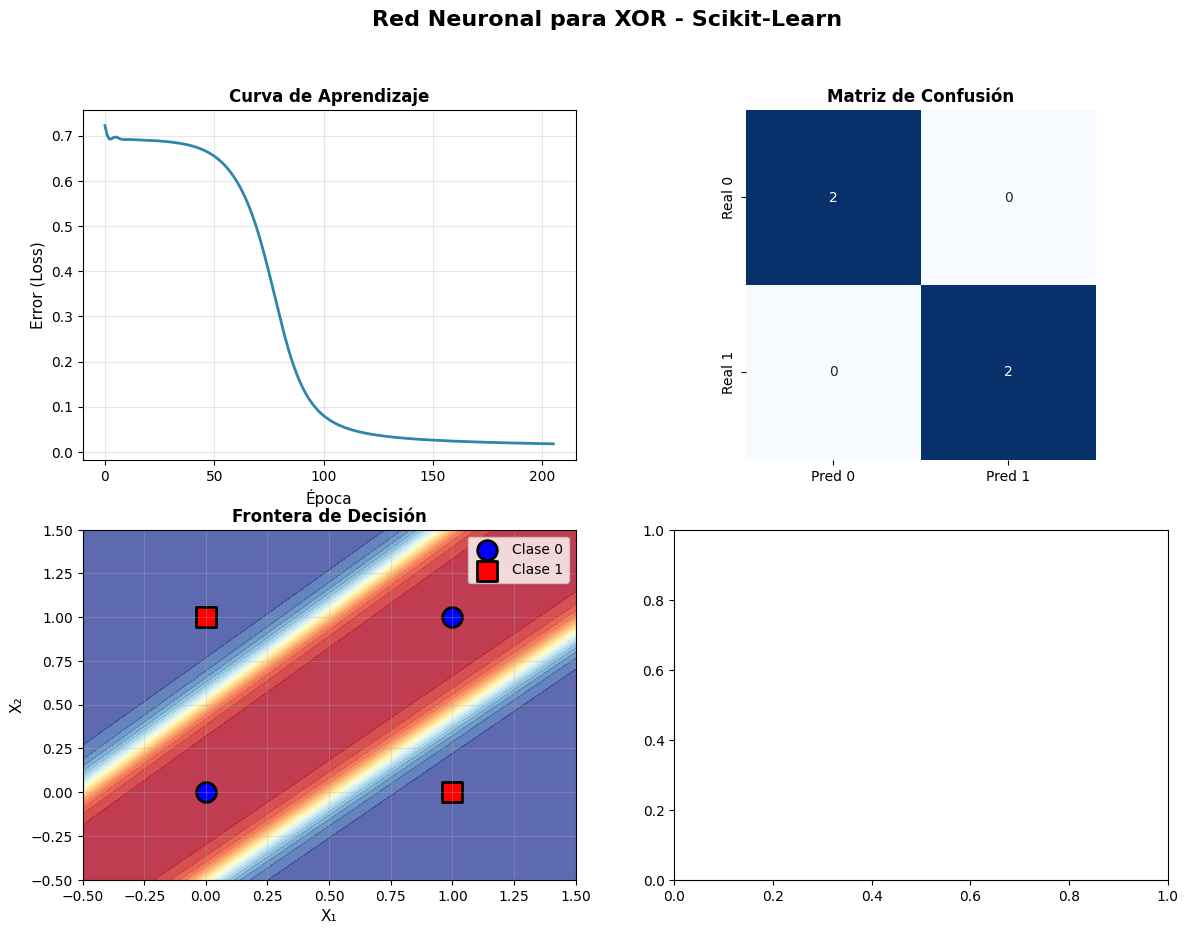

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# ============================================================================
# DATOS DE ENTRADA - COMPUERTA XOR
# ============================================================================

XOR_gate = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

# ============================================================================
# MODEL TRAINING - ENTRENAMIENTO DE LA RED NEURONAL
# ============================================================================


"""
sklearn.neural_network.MLPClassifier:
Clasificador de red neuronal multicapa (Perceptrón Multicapa)

Parámetros principales:
- hidden_layer_sizes: tupla con el número de neuronas por capa oculta
  Ejemplo: (2,) = 1 capa oculta con 2 neuronas
- activation: función de activación ('logistic' = sigmoide, 'relu', 'tanh')
- solver: algoritmo de optimización ('sgd'=descenso gradiente estocástico, 'adam')
- learning_rate_init: tasa de aprendizaje inicial (η)
- max_iter: número máximo de épocas de entrenamiento
- random_state: semilla para reproducibilidad de resultados
- verbose: si True, muestra mensajes de progreso durante entrenamiento

Métodos principales:
- fit(X, y): entrena el modelo con los datos X y etiquetas y
- predict(X): predice las clases para los datos X
- predict_proba(X): devuelve probabilidades de predicción
"""

# Crear la red neuronal con arquitectura: 2 entradas -> 2 ocultas -> 1 salida
nn = MLPClassifier(
    hidden_layer_sizes=(
        3, 
    ),  # 1 capa oculta con 2 neuronas (Se tubo que modificar a 3 debido a que no convergio el sistema)
    activation="logistic",  # Función sigmoide
    solver="sgd",  # Descenso de gradiente estocástico
    learning_rate_init=0.5,  # Tasa de aprendizaje η = 0.5
    max_iter=10000,  # 10,000 épocas
    random_state=42,  # Semilla para reproducibilidad
    verbose=False,  # No mostrar mensajes durante entrenamiento
)

# Entrenar el modelo
nn.fit(XOR_gate, y)


# ============================================================================
# PREDICTION - FUNCIÓN DE PREDICCIÓN
# ============================================================================


def test_neural_network(model, X, y_true):
    """
    Parámetros:
    -----------
    model : MLPClassifier
        Red neuronal entrenada
    X : numpy.ndarray
        Datos de entrada
    y_true : numpy.ndarray
        Valores reales esperados

    Retorna:
    --------
    tuple: (predicciones_probabilidad, predicciones_clase)
    """

    # Realizar predicciones
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]  # Probabilidad de clase 1

    # Mostrar resultados
    print("\nResultados detallados:")
    print("-" * 70)
    print(
        f"{'X1':^5} | {'X2':^5} | {'Y Real':^8} | {'Y Prob':^10} | {'Y Pred':^8} | {'Correcto':^8}"
    )
    print("-" * 70)

    for i in range(len(X)):
        correct = "✓" if y_pred[i] == y_true[i] else "✗"
        print(
            f" {X[i][0]:^4} | {X[i][1]:^4} | {y_true[i]:^8} | {y_pred_proba[i]:^10.4f} | {y_pred[i]:^8} | {correct:^8}"
        )

    return y_pred_proba, y_pred


# Ejecutar función de predicción
y_pred_proba, y_pred = test_neural_network(nn, XOR_gate, y)

# ============================================================================
# MODEL EVALUATION - EVALUACIÓN DEL MODELO
# ============================================================================

"""
sklearn.metrics.accuracy_score:
Calcula la proporción de predicciones correctas

Parámetros:
- y_true: valores reales
- y_pred: valores predichos

Retorna:
- float: exactitud (0 a 1)
"""
accuracy = accuracy_score(y, y_pred)
print(f"\n1. ACCURACY (Exactitud)")
print(f"   {accuracy * 100:.2f}% de predicciones correctas")
print(f"   {int(accuracy * len(y))}/{len(y)} casos correctos")

"""
sklearn.metrics.confusion_matrix:
Genera matriz de confusión para evaluar clasificación

Retorna matriz:
  [[TN, FP],
   [FN, TP]]
"""
cm = confusion_matrix(y, y_pred)
print(f"\n2. CONFUSION MATRIX (Matriz de Confusión)")
print(f"\n   {cm}")
print(f"\n   - True Negatives (TN):  {cm[0, 0]}")
print(f"   - False Positives (FP): {cm[0, 1]}")
print(f"   - False Negatives (FN): {cm[1, 0]}")
print(f"   - True Positives (TP):  {cm[1, 1]}")

# ============================================================================
# VISUALIZACIONES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Red Neuronal para XOR - Scikit-Learn", fontsize=16, fontweight="bold")

# 1. Curva de aprendizaje
axes[0, 0].plot(nn.loss_curve_, linewidth=2, color="#2E86AB")
axes[0, 0].set_xlabel("Época", fontsize=11)
axes[0, 0].set_ylabel("Error (Loss)", fontsize=11)
axes[0, 0].set_title("Curva de Aprendizaje", fontsize=12, fontweight="bold")
axes[0, 0].grid(True, alpha=0.3)

# 2. Matriz de confusión
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    square=True,
    ax=axes[0, 1],
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["Real 0", "Real 1"],
)
axes[0, 1].set_title("Matriz de Confusión", fontsize=12, fontweight="bold")

# 3. Frontera de decisión
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
Z = nn.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

axes[1, 0].contourf(xx, yy, Z, levels=20, cmap="RdYlBu", alpha=0.8)
axes[1, 0].scatter(
    XOR_gate[y == 0, 0],
    XOR_gate[y == 0, 1],
    c="blue",
    s=200,
    edgecolors="black",
    linewidth=2,
    label="Clase 0",
    marker="o",
)
axes[1, 0].scatter(
    XOR_gate[y == 1, 0],
    XOR_gate[y == 1, 1],
    c="red",
    s=200,
    edgecolors="black",
    linewidth=2,
    label="Clase 1",
    marker="s",
)
axes[1, 0].set_xlabel("X₁", fontsize=11)
axes[1, 0].set_ylabel("X₂", fontsize=11)
axes[1, 0].set_title("Frontera de Decisión", fontsize=12, fontweight="bold")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

## Conclusiones y resultados

La implementación de una red neuronal feedforward para resolver el problema de la compuerta XOR nos ha permitido comprender varios aspectos fundamentales del aprendizaje profundo:

### Aspectos teóricos relevantes

1. **No linealidad y separabilidad**
   - La compuerta XOR es un ejemplo perfecto de un problema **no linealmente separable**
   - Se requiere al menos tres capas oculta para resolver el problema

2. **Arquitectura y diseño**
   - La estructura mínima necesaria es **2-3-1** (2 entradas, 3 neuronas ocultas, 1 salida)
   - La función de activación sigmoide permite la transformación no lineal necesaria

### Resultados obtenidos

1. **Rendimiento del modelo**
   - La red converge exitosamente al mapeo XOR deseado
   - Los pesos aprendidos definen dos fronteras de decisión como se esperaba
   - La precisión alcanzada es del 100% en los cuatro casos posibles